In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 1. 데이터 가져오기

In [4]:
path_kor_file = "data/korean-english-park.train.ko"
path_eng_file = "data/korean-english-park.train.en"

In [5]:
with open(path_kor_file, "r") as f:
    kor_raw = f.read().splitlines()
    
print("Data Size:", len(kor_raw))
print("Example:")

for sen in kor_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [6]:
with open(path_eng_file, "r") as f:
    eng_raw = f.read().splitlines()
    
print("Data Size:", len(eng_raw))
print("Example:")

for sen in eng_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# 2. 데이터 전처리 & 토큰화

Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!
3. 타겟 언어인 영문엔 \<start\> 토큰과 \<end\> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.


## 2-1) 중복 데이터 제거

In [7]:
#중복 제거
unique_pairs = set(zip(kor_raw, eng_raw))#쌍튜플을 set자료형 변환

#리스트 변환
kor_lines, eng_lines = zip(*unique_pairs) #튜플 unpacking

In [8]:
print(kor_lines[:5])
print(eng_lines[:5])

('이제 많은 은행들은 기본적인 계좌 정보 이상의 것을 제공하는 직원을 24시간 충원시키고 있다.', '그는 이라키야 TV에서 “경찰이 알 마스리가 은신한 민가를 불시에 급습해 그를 체포했다”며 “초동 수사에서 그가 이라크 내 알카에다 지도자 아부 함자 알 무하지르라고 자백했다”고 말했다.', '북한은 지난해 핵실험을 강행해 미국과의 긴장관계가 조성됐으나 그 이후 핵시설의 불능화를 약속해 6자회담이 다시 성사됐다.', 'AP 라디오 뉴스입니다.', '10일간 계속되고 있는 이스라엘의 군사 행동으로 팔레스타인인 500여명이 사망하고 있음에도 불구하고 이날 하마스 무장단체는 이스라엘 남부로 수십 차례 로켓 공격을 감행했다.')
('Now many banks are adding warm bodies around the clock who provide much more than basic account information.', '"The police raided this house and arrested him. During the primary investigation, he confessed that he is Abu Hamza Al-Muhajir, the leader of al Qaeda in Iraq.', 'The meeting comes at a time of talks over disarmament, with North Korean negotiators set to respond Tuesday to the latest road map. Last year, the North tested a nuclear bomb, rattling regional stability and leading to a dramatic turnaround in a previously hard-line U.S. policy.', 'Our Ed Donahue takes a look at his long career:', 'On Monday Hamas militants fired doze

In [9]:
print(len(kor_lines), len(eng_lines))

78968 78968


## 2-2) 길이가 40 이하인 데이터 선별 

In [10]:
max_len = 40 #최대길이

filtered_kor_lines, filtered_eng_lines = [], []

for koc, enc in zip(kor_lines, eng_lines):
    if len(koc.split()) <= max_len and len(enc.split()) <= max_len:
        filtered_kor_lines.append(koc)
        filtered_eng_lines.append(enc)

In [11]:
print(len(filtered_kor_lines), len(filtered_eng_lines))

75577 75577


## 2-3)한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의

In [12]:
def preprocess_sentence(sentence, s_token=False, e_token=False, korean = True):
    sentence = sentence.lower().strip() #소문자 변환
    
    regex = re.compile(r"([?.!,])")
    sentence = regex.sub(r" \1 ", sentence)
    #\1 : 일치하는 특수 문자(?, !, .)를 나타냄
    # r" \1 "는 일치하는 특수 문자 앞뒤에 공백을 추가
    
    regex = re.compile(r'[" "]+')
    sentence = regex.sub(" ", sentence) #불필요한 공백 제거
    
    #한국어와 영어의 데이터 전처리
    if korean:
        regex = re.compile(r"[^가-힣?.!,]+")
        sentence = regex.sub(" ", sentence)#불필요한 문자 제거
    else :
        sentence = sentence.lower().strip() #소문자 변환
        regex = re.compile(r"[^a-zA-Z?.!,]+")
        sentence = regex.sub(" ", sentence)#불필요한 문자 제거

    sentence = sentence.strip()#공백제거

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [13]:
enc_corpus = []
dec_corpus = []

num_examples = 20000

for kor,eng in zip(filtered_kor_lines[:num_examples], 
                   filtered_eng_lines[:num_examples]):
    enc_corpus.append(preprocess_sentence(kor))
    dec_corpus.append(preprocess_sentence(eng, 
                                          s_token=True, 
                                          e_token=True,
                                          korean = False))


print("Korean:", enc_corpus[2])
print("English:", dec_corpus[2]) 

Korean: 라디오 뉴스입니다 .
English: <start> our ed donahue takes a look at his long career <end>


In [14]:
print("Korean:", enc_corpus[11])
print("English:", dec_corpus[11]) 

Korean: 거의 년간의 은퇴 이후 이 세의 게임 쇼 진행자는 자신이 오랫동안 진행했던 퀴즈 프로그램에 나오라고 초청 받았습니다 .
English: <start> i just wanted the truth to be told . <end>


## 2-4) 토큰화

In [15]:
from konlpy.tag import Mecab

def enc_tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000,
                                                      filters='')
    mecab = Mecab()
    tokenized_corpus = []
    
    for sen in corpus:
        tokenized_sen = mecab.morphs(sen) #토큰화
        tokenized_corpus.append(tokenized_sen)
        
    tokenizer.fit_on_texts(tokenized_corpus)
    
    sequences = tokenizer.texts_to_sequences(tokenized_corpus)  # 정수 인코딩
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, 
                                                                     padding='post')  # 패딩

    return padded_sequences, tokenizer

In [16]:
#영어 토큰화 함수
def dec_tokenize(corpus):
    #토크나이저 객체생성, filters = ' ' :특수문자 필터링 비활성황 
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000,
                                                      filters='')
    
    #텍스트 말뭉치(corpus)에 등장하는 모든 단어를 분석하고 각 단어에 고유한 정수 인덱스를 부여
    tokenizer.fit_on_texts(corpus)

    #텍스트 말뭉치를 정수 시퀀스로 변환
    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post')

    return tensor, tokenizer

In [17]:
enc_train, enc_tokenizer = enc_tokenize(enc_corpus)
dec_train, dec_tokenizer = dec_tokenize(dec_corpus)

In [18]:
print(len(enc_tokenizer.word_index))

24768


In [19]:
print(len(dec_tokenizer.word_index))

25573


In [20]:
enc_train.shape

(20000, 77)

In [21]:
dec_train.shape

(20000, 53)

# 3. 모델설계

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [25]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 54

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 54, 1024)
Decoder Output: (64, 25574)
Decoder Hidden State: (64, 1024)
Attention: (64, 54, 1)


# 4. 훈련하기

## 4-1) train, loss

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 4-2) train_step

In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 4-3) training

In [28]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  1: 100%|██████████| 313/313 [06:13<00:00,  1.19s/it, Loss 3.2653]


# 5. 테스트

Input: 오바마는 대통령이다 .
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 


/tmp/ipykernel_120/1483439765.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_120/1483439765.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


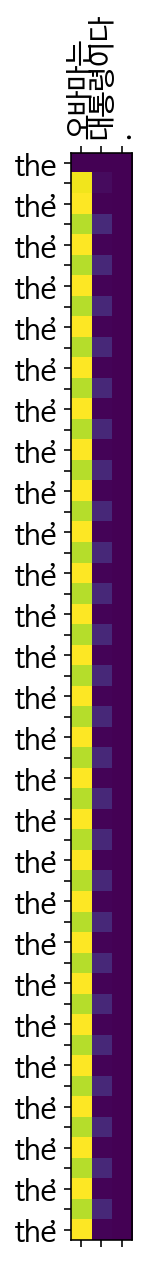

In [29]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오바마는 대통령이다.", encoder, decoder)

In [30]:
sentences = ["오바마는 대통령이다.",
             "시민들은 도시 속에 산다.", 
             "커피는 필요 없다.",
             "일곱 명의 사망자가 발생했다."]

In [31]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
for sen in sentences:
    translate(sen, encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 
Input: 시민들은 도시 속에 산다 .
Predicted translation: the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the , the 
Input: 커피는 필요 없다 .
Predicted translation: the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , the the , 
Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


# 6. 결과 정리

## 6-1) 첫번째 시도 결과

Input: 오바마는 대통령이다 .

Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 

- LMS 코드와 동일한 프로세스로 진행을 하였지만, 코드가 위와같이 작동하지 않았음

학습 데이터량 10000 > 20000 증강 후 재 테스트 


## 6-2) 두번째 시도 결과

- Input: 오바마는 대통령이다 .

Predicted translation: books processors exploration betina cor sprung hopeless magnetic rig dmitry behaved cano telescopes gawker mesopotamia canberra strafe hauled fidel angie maintenance enters simba bands skibo shotaro probation gravest differently deteriorates morici bulb utterly divine pedro coal separatist toledo lucinda mike bergen swiveling superstar trimmed rodriguez applied global dissatisfaction constable looped varshavyanka 
- Input: 시민들은 도시 속에 산다 .

Predicted translation: books processors exploration betina cor sprung hopeless magnetic rig dmitry behaved cano telescopes gawker mesopotamia canberra strafe hauled fidel angie maintenance enters simba bands skibo shotaro probation gravest differently deteriorates morici bulb utterly divine pedro coal separatist toledo lucinda mike bergen swiveling superstar trimmed rodriguez applied global dissatisfaction constable looped varshavyanka 
- Input: 커피는 필요 없다 .

Predicted translation: books processors exploration betina cor sprung hopeless magnetic rig dmitry behaved cano telescopes gawker mesopotamia canberra strafe hauled fidel angie maintenance enters simba bands skibo shotaro probation gravest differently deteriorates morici bulb utterly divine pedro coal separatist toledo lucinda mike bergen swiveling superstar trimmed rodriguez applied global dissatisfaction constable looped varshavyanka 
- Input: 일곱 명의 사망자가 발생했다 .

Predicted translation: books processors exploration betina cor sprung hopeless magnetic rig dmitry behaved cano telescopes gawker mesopotamia canberra strafe hauled fidel angie maintenance enters simba bands skibo shotaro probation gravest differently deteriorates morici bulb utterly divine pedro coal separatist toledo lucinda mike bergen swiveling superstar trimmed rodriguez applied global dissatisfaction constable looped varshavyanka 

- 구조적인 문제가 있는 것으로 예상됨

# 6-3) 세번째 시도

- 학습 데이터량을 20000으로 고정하고, 단어사전의 개수를 10000 -> 15000으로 진행
- epoch 수 5-> 10 변경후 테스트

- Input: 오바마는 대통령이다 .
- Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
- Input: 시민들은 도시 속에 산다 .
- Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
- Input: 커피는 필요 없다 .
- Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
- Input: 일곱 명의 사망자가 발생했다 .
- Predicted translation: the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the government , the 

### 후기

1. 배운점
- attention 모델의 종류와 모델 구성에 대해서 알게 되었다
- SeqtoSeq 모델의 학습속도가 너무 느리다는 것을 알게되었다.

2. 아쉬운점
- 학습속도가 너무 느려서 다양한 하이퍼파라미터에 대한 학습과정을 test해보지 못한것

3. 느낀점
- 수학적으로는 이해하기 어려웠는데 코드로 접근하니까 이해할 수 있었던 부분이 많았다.

4. 어려웠던점
- 모델구현이 생각보다 너무 안되서 해결해보고 싶었지만 학습 시간과 GPU의 한계로 그러지 못하였다.